In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import nibabel as nib
from nilearn.plotting import plot_glass_brain

/Users/snastase/opt/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Convenience function for converting to NIfTI
def nii(data, affine, header=None):
    return nib.Nifti1Image(data, affine, header=header)

In [3]:
# Create double colormap to full nilearn
def double_cmap(cm=plt.cm.inferno, n_colors=12): 
    double_c = np.vstack((cm(np.linspace(0, 1, n_colors)),
                          cm(np.linspace(0, 1, n_colors))))
    return colors.ListedColormap(double_c)

In [10]:
# Reconstruct parcel values in whole brain
def resample_parcels(parcel_data, atlas, brain_shape):
    brain_data = np.zeros(brain_shape)
    for i, parcel in enumerate(parcel_data):
        brain_data[atlas == i + 1] = parcel
    return brain_data

In [4]:
# Load in ROI labels and visualize
roi_labels = np.load('parcel_roi_labels.npy')
roi_names = ['L_PostTemp', 'L_AntTemp', 'L_AngG', 'L_IFG', 'L_MFG',
             'L_IFGorb', 'L_vmPFC', 'L_dmPFC', 'L_PMC', 'L_HG', 'L_V1',
             'R_PostTemp', 'R_AntTemp', 'R_AngG', 'R_IFG', 'R_MFG',
             'R_IFGorb', 'R_vmPFC', 'R_dmPFC', 'R_PMC', 'R_HG', 'R_V1']

# Set V1 to zero and ignore
v1_ids = [i for i, r in enumerate(roi_names) if 'V1' in r]
for v1_id in v1_ids:
    roi_labels[roi_labels == v1_id + 1.] = 0.

roi_ids = np.where(roi_labels != 0)[0]

In [6]:
# Load in downsampled Schaefer parcellation
atlas_f = 'schaefer_resample.nii.gz'
atlas_nii = nib.load(atlas_f)
affine, header = atlas_nii.affine, atlas_nii.header

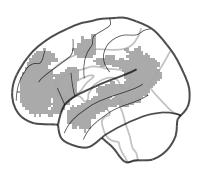

In [55]:
# Visualize language ROIs
lang_rois = (roi_labels > 0).astype(float)
roi_map = resample_parcels(lang_rois, atlas_nii.get_fdata(),
                           atlas_nii.shape)
plot_glass_brain(nii(roi_map, affine), display_mode='l',
                 cmap='binary_r', vmax=3);
plt.savefig('language_network.svg', bbox_inches='tight',
            transparent=True, dpi=300)

In [71]:
# Load in embeddings (layers 1-12) and transformations
parcel_emb = np.load('embeddings_performances.npy')[1:]
parcel_z = np.load('transformations_performances.npy')

In [72]:
# Truncate extreme percent noise ceiling values
parcel_emb[parcel_emb > 100] = 100
parcel_emb[parcel_emb < -100] = -100

parcel_z[parcel_z > 100] = 100
parcel_z[parcel_z < -100] = -100

In [73]:
# Average performances acrosss subjects
parcel_emb_mean = np.mean(parcel_emb, axis=1)
parcel_z_mean = np.mean(parcel_z, axis=1)

In [74]:
# Get layer with max performance
parcel_emb_max = np.argmax(parcel_emb_mean, axis=0) + 1
parcel_z_max = np.argmax(parcel_z_mean, axis=0) + 1

In [75]:
# Get average performance across subjects at preferred layer
parcel_emb_val = np.amax(parcel_emb_mean, axis=0)
parcel_z_val = np.amax(parcel_z_mean, axis=0)

In [76]:
# Select only parcels in language ROIs
parcel_emb_roi = parcel_emb_max.copy()
parcel_emb_roi[roi_labels == 0] = 0

parcel_z_roi = parcel_z_max.copy()
parcel_z_roi[roi_labels == 0] = 0

In [89]:
# Threshold preferred layer by performance
def threshold_parcels(parcel_data, thresh):
    parcel_thresh = np.zeros(parcel_data.shape)
    parcel_thresh[thresh] = parcel_data[thresh]
    return parcel_thresh
    
thresh = np.logical_and(parcel_emb_val > 15, parcel_z_val > 15)
#thresh = np.logical_or(thresh, roi_labels != 0)

parcel_emb_thresh = threshold_parcels(parcel_emb_max, thresh)
parcel_z_thresh = threshold_parcels(parcel_z_max, thresh)

In [47]:
# Resample parcelwise preferred layers onto brain
brain_emb_max = resample_parcels(parcel_emb_max, atlas_nii.get_fdata(),
                                 atlas_nii.shape)
brain_z_max = resample_parcels(parcel_z_max, atlas_nii.get_fdata(),
                               atlas_nii.shape)

In [90]:
# Resample thresholded parcels onto brain
brain_emb_thresh = resample_parcels(parcel_emb_thresh, atlas_nii.get_fdata(),
                                    atlas_nii.shape)
brain_z_thresh = resample_parcels(parcel_z_thresh, atlas_nii.get_fdata(),
                                  atlas_nii.shape)

In [81]:
# Resample language ROI parcels onto brain
brain_emb_roi = resample_parcels(parcel_emb_roi, atlas_nii.get_fdata(),
                                 atlas_nii.shape)
brain_z_roi = resample_parcels(parcel_z_roi, atlas_nii.get_fdata(),
                               atlas_nii.shape)

In [50]:
# Create doubled colormap for nilearn
cm = plt.cm.Spectral
cmap = double_cmap(cm=cm, n_colors=12)

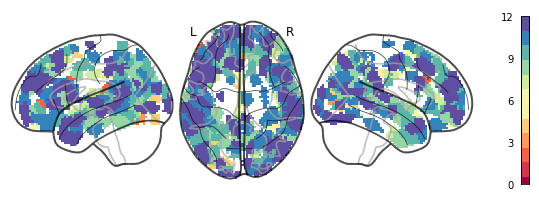

In [91]:
# Plot thresholded preferred embedding layer on glass brain
plot_glass_brain(nii(brain_emb_thresh, affine=affine), 
                 threshold=0, display_mode='lzr',
                 colorbar=True, cmap=cmap, 
                 vmax=12);

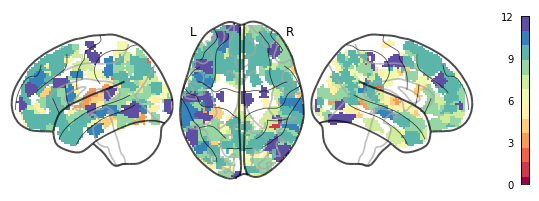

In [92]:
# Plot thresholded preferred transformation layer on glass brain
plot_glass_brain(nii(brain_z_thresh, affine=affine), 
                 threshold=0, display_mode='lzr',
                 colorbar=True, cmap=cmap, 
                 vmax=12);

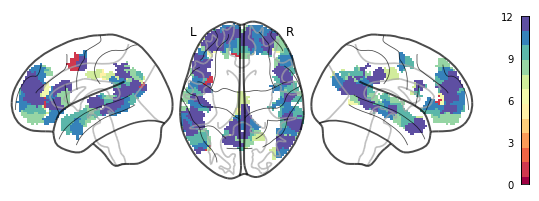

In [82]:
# Plot language ROI preferred embedding layer on glass brain
plot_glass_brain(nii(brain_emb_roi, affine=affine), 
                 threshold=0, display_mode='lzr',
                 colorbar=True, cmap=cmap, 
                 vmax=12);

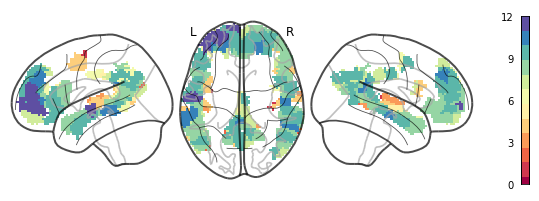

In [83]:
# Plot language ROI preferred transformation layer on glass brain
plot_glass_brain(nii(brain_z_roi, affine=affine), 
                 threshold=0, display_mode='lzr',
                 colorbar=True, cmap=cmap, 
                 vmax=12);

In [88]:
# Save NIfTI images to file for plotting
nii(brain_emb_thresh, affine).to_filename('bert_layer_emb_thresh10.nii.gz')
nii(brain_z_thresh, affine).to_filename('bert_layer_z_thresh10.nii.gz')

In [22]:
# Save NIfTI images to file for plotting
nii(brain_emb_roi, affine).to_filename('bert_layer_emb_roi.nii.gz')
nii(brain_z_roi, affine).to_filename('bert_layer_z_roi.nii.gz')

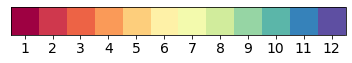

In [23]:
# Create custom colorbar image
a = np.arange(1, 13)[np.newaxis, :]

fig, ax = plt.subplots()
ax.imshow(a, cmap='Spectral')
plt.xticks(np.arange(12), np.arange(1, 13), fontsize=14)
plt.yticks([]);
plt.savefig('spectral_12_colorbar_x.png', bbox_inches='tight',
            transparent=True, dpi=300)

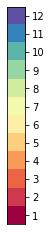

In [24]:
# Create custom colorbar image
a = np.arange(1, 13)[:, np.newaxis]

fig, ax = plt.subplots()
ax.imshow(a, cmap='Spectral_r')
plt.yticks(np.arange(12), np.arange(1, 13)[::-1])
plt.xticks([]);
ax.yaxis.tick_right()
plt.savefig('spectral_12_colorbar_yright.png', bbox_inches='tight',
            transparent=True, dpi=300)